In [49]:
import utils as u
from importlib import reload
from sklearn.model_selection import train_test_split
import fla_parallelized as a
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time
import numpy as np
from sklearn.metrics import f1_score
import pickle as pkl

In [2]:
X, y, weight = u.diabetes_data()

In [56]:
reload(a)
head_counts = [3]#,2,3,4,5,6,7,8,9,10,15,20]
test_prediction_dict = {h: [] for h in head_counts}
test_label_list = []
losses = {h: [] for h in head_counts}

forward_times = []
loss_times = []
backwards_times = []
optimizer_times = []

for seed in range(10):
    for i, head in enumerate(head_counts):
        print(f'seed {seed+1}, with {head} heads')
        #split data
        X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.2, random_state=seed)
        X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, stratify=y_train, test_size=0.1, random_state=seed)
        train_dataset = a.npDataset(X_train,y_train)
        test_dataset = a.npDataset(X_test,y_test)
        val_dataset = a.npDataset(X_val,y_val)
        batch_size = 64
        train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        #make model
        hidden_dims = [50,25,10]
        attn_heads = head
        model = a.TabularAwarenessNetwork(input_dim=108, hidden_dims=hidden_dims, output_dim=1, 
                                          n_heads=attn_heads, agg='proj', activation=nn.ReLU(), mech='film')
        criterion = nn.BCEWithLogitsLoss(pos_weight=weight)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        #train
        num_epochs = 500
        best_val_loss = float('inf')
        best_model = None
        patience = 10
        early_stop_counter = 0
        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                start_f = time.time()
                outputs = model(inputs)
                end_f = time.time()
                # print(f'forwards: {end_f-start_f:.4f}')
                forward_times.append(end_f-start_f)
                labels = labels.unsqueeze(1)
                start_l = time.time()
                loss = criterion(outputs, labels)
                end_l = time.time()
                loss_times.append(end_l-start_l)
                start_b = time.time()
                loss.backward()
                end_b = time.time()
                # print(f'back: {end_b-start_b:.4f}')
                backwards_times.append(end_b-start_b)
                start_o = time.time()
                optimizer.step()
                end_o = time.time()
                optimizer_times.append(end_o-start_o)

            model.eval()
            val_losses = []
            for inputs, labels in val_loader:
                with torch.no_grad():
                    outputs = model(inputs)
                    labels = labels.unsqueeze(1)
                    val_loss = criterion(outputs, labels)
                    val_losses.append(val_loss.item())
            
            avg_val_loss = np.mean(val_losses)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = model.state_dict()
                early_stop_counter = 0
            else:
                early_stop_counter += 1
            
            if early_stop_counter >= patience:
                print(f'Early stopping after epoch {epoch+1} with validation loss {best_val_loss:.4f}')
                break
            
        model.load_state_dict(best_model)

        #eval
        test_losses = []
        test_predictions = []
        test_true_labels = []

        for inputs, labels in test_loader:
            with torch.no_grad():
                outputs = model(inputs)
                labels = labels.unsqueeze(1)
                test_loss = criterion(outputs, labels)
                test_losses.append(test_loss.item())
                test_predictions.extend(outputs.cpu().numpy())
                test_true_labels.extend(labels.cpu().numpy())
        avg_test_loss = np.mean(test_losses)
        test_predictions_f1 = [y>0.5 for y in test_predictions]
        test_score = f1_score(test_true_labels, test_predictions_f1)
        print(f'Test Loss: {avg_test_loss:.4f}, Test Score: {test_score:.4f} for seed {seed+1} and {head} heads.')
        if i == 0:
            test_label_list.append(test_true_labels)
        test_prediction_dict[head].append(test_predictions)
        losses[head].append(avg_test_loss)
# with open ("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/diabetes/film/test_pred_dict_1_to_4.pkl", "wb") as file:
#     pkl.dump(test_prediction_dict, file=file)
# with open ("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/diabetes/film/test_losses_dict_1_to_4.pkl", "wb") as file:
#     pkl.dump(losses, file=file)
# with open ("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/diabetes/film/test_labels.pkl", "wb") as file:
#     pkl.dump(test_label_list, file=file)

seed 1, with 3 heads
Epoch 1, Validation Loss: 1.1101
Epoch 2, Validation Loss: 1.1183
Epoch 3, Validation Loss: 1.1319
Epoch 4, Validation Loss: 1.1320
Epoch 5, Validation Loss: 1.1351
Epoch 6, Validation Loss: 1.1155
Epoch 7, Validation Loss: 1.1078
Epoch 8, Validation Loss: 1.1241
Epoch 9, Validation Loss: 1.1034
Epoch 10, Validation Loss: 1.1235
Epoch 11, Validation Loss: 1.1355
Epoch 12, Validation Loss: 1.1479
Epoch 13, Validation Loss: 1.1456
Epoch 14, Validation Loss: 1.1107
Epoch 15, Validation Loss: 1.1214
Epoch 16, Validation Loss: 1.1155
Epoch 17, Validation Loss: 1.1270
Epoch 18, Validation Loss: 1.1415
Epoch 19, Validation Loss: 1.1702
Early stopping after epoch 19 with validation loss 1.1034
Test Loss: 1.2097, Test Score: 0.2695 for seed 1 and 3 heads.
seed 2, with 3 heads
Epoch 1, Validation Loss: 1.1978
Epoch 2, Validation Loss: 1.1481
Epoch 3, Validation Loss: 1.1052
Epoch 4, Validation Loss: 1.1299
Epoch 5, Validation Loss: 1.1039
Epoch 6, Validation Loss: 1.0989
Epo

In [57]:
for k,v in losses.items():
    print(k, np.median(v))

3 1.1883294240882


In [58]:
fmaxes = {}
for k,v in test_prediction_dict.items():
    fmaxes[k] = []
    for i in range(10):
        activated_preds = [u.sig(x) for x in v[i]]
        fmaxes[k].append(u.fmax_score(test_label_list[i], activated_preds)[0])
    print(k, np.median(fmaxes[k]))

3 0.3032605967970069


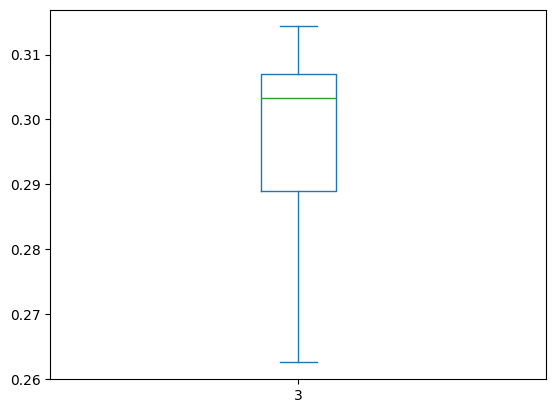

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
fmaxes_df = pd.DataFrame(fmaxes)
fmaxes_df.plot.box()
plt.show()

In [35]:
import pickle as pkl
with open ("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/film/sum/diabetes/test_pred_dict.pkl", "wb") as file:
    pkl.dump(test_prediction_dict, file=file)
with open ("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/film/sum/diabetes/test_losses_dict.pkl", "wb") as file:
    pkl.dump(losses, file=file)
with open ("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/film/sum/diabetes/test_labels.pkl", "wb") as file:
    pkl.dump(test_label_list, file=file)